# Relax data science challenge

*Lukas Vlcek*

**Data wrangling**

The complete input data consisted of two datasets (in the form of CSV files), which were converted to pandas dataframes for further analysis. The engagement dataset was used to extract information about adoption of individual users. This was achieved by aggregating engagement events over a moving 7-day window for each user, using 'groupby' and 'rolling' functionality provided by pandas library. The resulting indicator of adoption was added as a new feature to the 'users' dataframe for subsequent analysis.

**Statistical analysis**

After converting the user data for analysis by creating dummy variables for categorical features, logistic regression fit was used to identify the most predictive parameters. This was achieved using statsmodels library. The magnitude and statistical significance of the parameters showed that the most informative feature is creation_source. Among these 'Guest invite' and 'Signup_google_auth' are the most significant predictors of adoption, while 'Personal project' is the most significant negative predictor of adoption. The mailing list opt-in, is not a very strong indicator of adoption, and marketing drip even indicates (with low statistical significance) that it may have a negative effect on adoption.

**Predictive modeling**

The predictive value of provided data was assessed by considering the model quality metrics of an optimized logistic regression model. After grid search hyperparamter optimization, which selected the optimal penalty (L1) and regularization parameter (~5), the model was evaluated. Scoring based on ROC AUC was chosen because the default accuracy measure does not provide useful information for the present imbalanced dataset with only mildly informative predictor variables. In this case the higher accuracy is achieved by simply predicting 'non-adoption' for every user. This *a priori* information is contained in the intercept of the logistic regression model. Basic prediction qaulity metrics of the model are shown in the corresponding plots.

![](./model_characteristics.png)

While, the predictive value of the model is not large, it still provides useful guidance for choosing the areas of focus to increase adoption.

**Redommendations**

These results suggest that encouraging guest invites (maybe with incentives) may be a promising path to increasing adoption. The actual causal effect could be verified using an A/B test. On the other hand marketing drip may be wasting resources.


** Code for the analysis is provided below **

## Code for analysis

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

### Data wrangling

Read CSV files and explore the dataset properties

In [2]:
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1", parse_dates=['creation_time'])
engagement = pd.read_csv('takehome_user_engagement.csv', encoding = "ISO-8859-1", parse_dates=['time_stamp'])

In [3]:
users = users.set_index('object_id')
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Based on engagement data, identify adopted users, and then add the corresponding feature to the users dataframe.

Adopted user: logged into the product on three separate days in at least one seven day period

In [5]:
# group by user_id
user_group = engagement.groupby('user_id')

# use moving window of 7 days for each group (user_id) and count visits
agg = user_group.rolling('7d', on='time_stamp')['visited'].sum()#.to_frame()

# check if any 7 day period for each user has 3 or more visits, and label it as adopted
adopted = agg.groupby('user_id').max() >= 3

# add this info to 'users' dataframe
users['adopted'] = adopted
users['adopted'] = users['adopted'].fillna(False).astype(int)
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0).astype(int)
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0


In [6]:
print('Percentage of adopted users:', 100*users['adopted'].sum()/users.shape[0],'%')

Percentage of adopted users: 13.35 %


### Modeling

One way to identify important factors is to fit a logistic regression model for classification of user adoption.

**Prepare data for modeling**

In [7]:
users_model = pd.get_dummies(users, columns=['creation_source'])#, drop_first=True)
users_model = users_model.drop('creation_source_PERSONAL_PROJECTS', axis=1)
users_model.head()

,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803,0,1,0,0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316,1,0,1,0,0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525,0,0,1,0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151,0,1,0,0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240,0,1,0,0,0


Choose predictor and target variable

In [8]:
predictors = [column for column in users_model.columns if column[:15] == 'creation_source']
predictors.extend(['opted_in_to_mailing_list', 'enabled_for_marketing_drip','org_id'])
target = ['adopted']

Create training and testing datasets

In [9]:
X = users_model[predictors]
y = users_model[target]

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

**Statsmodels logistic regression**

In [11]:
Xtrain_sm = sm.add_constant(Xtrain) # include intercept
logreg_sm = sm.GLM(ytrain, Xtrain_sm, family=sm.families.Binomial()).fit()
summary_string = logreg_sm.summary().as_csv()
logreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                adopted   No. Observations:                 9600
Model:                            GLM   Df Residuals:                     9592
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -3719.7
Date:                Sun, 12 Aug 2018   Deviance:                       7439.3
Time:                        14:28:12   Pearson chi2:                 9.58e+03
No. Iterations:                     5                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -2.6617      0.098    -27.233      0.000      -2.853      -2.470
creation_source_GUEST_INVITE           0.7783      0.110      7.091      0.000       0.563       0.993
creation_source_ORG_INVITE             0.5194      0.102      5.094      0.000       0.320       0.719
creation_source_SIGNUP                 0.6307      0.113      5.602      0.000       0.410       0.851
creation_source_SIGNUP_GOOGLE_AUTH     0.8313      0.119      6.988      0.000       0.598       1.064
opted_in_to_mailing_list               0.0604      0.079      0.767      0.443      -0.094       0.215
enabled_for_marketing_drip            -0.0289      0.096     -0.299      0.765      -0.218       0.160
org_id                                 0.0015      0.000      6.407      0.000       0.001       0.002
======================================================================================================
"""

**Observation:** The most informative feature is creation_source. Among these 'Guest invite' and 'Signup_google_auth' are the most significant predictors of adoption, while 'Personal project' is the most significant predictor of *not* adoption. The mailing list opt in, is not a very strong indicator of adoption, and marketing drip even indicates (with low statistical significance) that it may have a negative effect on adoption.

In [12]:
ytrain = ytrain.values[:,0]
Xtrain = Xtrain.values
ytest = ytest.values[:,0]
Xtest = Xtest.values

Grid search hyperparamter optimization (penalty and regularization parameter).

Scoring based on ROC AUC was chosen since the default accuracy does not provide useful information for the present imbalanced dataset with only mildly informative predictor variables. In this case the higher accuracy is achieved by simpley predicting 'non-adoption' for every user.

In [13]:
param_grid = {'penalty':['l2', 'l1'], 'C':list(np.logspace(-4, 1, 40))}
grid_list = sorted(param_grid)
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=4, scoring='roc_auc')

In [14]:
_ = grid.fit(Xtrain, ytrain)

In [15]:
mean_scores = np.array(grid.cv_results_['mean_test_score']).reshape(40,2)
print('Maximum score:', mean_scores.max())
best_index = np.unravel_index(np.argmax(mean_scores, axis=None), mean_scores.shape)
print('Best hyperparameters:')
for i, j in enumerate(best_index):
    print(' ', grid_list[i],':', param_grid[grid_list[i]][j])

Maximum score: 0.588245435669
Best hyperparameters:
  C : 10.0
  penalty : l2


In [16]:
print('Accuracy on the training data:', grid.score(Xtrain, ytrain))
print('Accuracy on the testing data:', grid.score(Xtest, ytest))

Accuracy on the training data: 0.592688013011
Accuracy on the testing data: 0.604357381835


**ROC and PR characteristics**

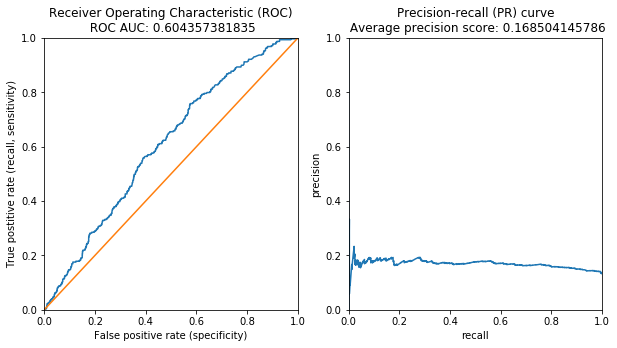

In [17]:
ytest_pred = grid.predict(Xtest)
ytest_pred_prob = grid.predict_proba(Xtest)

fprs, tprs, thresholds = roc_curve(ytest, ytest_pred_prob[:,1])
result = roc_auc_score(ytest, ytest_pred_prob[:,1])
#print('ROC AUC (start data):', result)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(fprs, tprs)
plt.plot([0,1],[0,1])
plt.axis([0,1,0,1])
plt.xlabel('False positive rate (specificity)')
plt.ylabel('True postitive rate (recall, sensitivity)')
plt.title("Receiver Operating Characteristic (ROC)\n ROC AUC: " + str(result))

ys_score = grid.decision_function(Xtest)
precision, recall, _ = precision_recall_curve(ytest, ys_score)
#print('Average precision score:', average_precision_score(ytest, ys_score))
result = average_precision_score(ytest, ys_score)
plt.subplot(122)
plt.plot(recall, precision)
#plt.plot([0,1],[1,0])
plt.axis([0,1,0,1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precision-recall (PR) curve\n Average precision score: " + str(result))

plt.savefig('model_characteristics.png')

In [18]:
for i in range(len(predictors)):
    print(predictors[i], ':', grid.best_estimator_.coef_[0][i])

creation_source_GUEST_INVITE : 0.738435920797
creation_source_ORG_INVITE : 0.490456097471
creation_source_SIGNUP : 0.593314015838
creation_source_SIGNUP_GOOGLE_AUTH : 0.808065090896
opted_in_to_mailing_list : 0.0506078207288
enabled_for_marketing_drip : -0.0142953448777
org_id : 0.00148324749632


The logistic regression analysis using sklearn functionality (L1 penalty, optimized C) provides the same qualitative results as the one from statsmodels.